In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import json
import pdb

os.chdir('L:/analysis_nima/Python Scripts') #changing directory to ETL.py folder
from Analyses_ import ETL
from Analyses_ import findseq
from Analyses_ import slo_spi
%config Completer.use_jedi = False

### Input informations

In [2]:
all_address = ['L:/analysis_nima/250520_m18a/Batch_4', 'L:/analysis_nima/290520_m17a/Batch/extracells/Batch_2',
                'L:/analysis_nima/110620_m18b/new/Batch_3', 'L:/analysis_nima/050820_m21a/Batch_4',
                'L:/analysis_nima/030720_m20a/Batch_3', 'L:/analysis_nima/291020_m23a/Batch_2', 
               'L:/analysis_nima/210121_m24a/Batch_1']

# sampling rate for different mice
sfs = [30.995, 30.995, 30.955, 30.995, 30.995, 30.9576, 30.995]

# defining artifacts
custom_artifacts_1 = [[11007,11008,4]]
custom_artifacts_2 = [[11630,11947,0],[12000,12700,0],[4533,5154,14]]
custom_artifacts_3 = []
custom_artifacts_4 = [[1595,1845,0],[4609,4907,0],[7740,7983,0],[13795,14101,0],[16706,16973,0],
             [7266,7501,1],[11912,12219,1],[12703,13203,1],[13730,13909,1],[15097,15559,1],[17277,17519,1],
             [1416,1793,2],[3816,4123,2],[13254,13593,2],[15224,15703,2],[17668,18067,2],
             [7358,7521,3],[10240,10253,3],[13672,13748,3],[17306,17593,3],
             [5505,5939,4],[6222,6231,4],[16760,16820,4],[18450,18573,4],                           
             [1132,1357,7],[8653,8776,7],[9946,10391,7],
             [9068,9323,7],[13589,13623,7],[17394,17547,7],
             [1,140,8],[908,965,8],[7638,7665,8],[8014,8027,8],[14726,14922,8],[18022,18187,8],
             [1912,2381,9],[2920,2923,9],[7767,7819,9],[7864,7997,9],[9876,10197,9],[15206,15545,9],
             [6734,7220,10],[9668,9939,10],
             [8914,9290,11],[9562,9571,11],[12216,12339,11],
             [11492,11553,12],[13898,13919,12],
             [6298,6619,13],[12282,12795,13],[14406,14507,13],[14798,14875,13],
             [1,220,14],[1878,2108,14],[9872,9961,14],
             [4764,4813,15],[5564,5571,15],[15419,15595,15],[16003,16089,15],[16420,16482,15],
             [4240,4403,16],[9975,10077,16],[10274,10275,16],[13228,13451,16],[13805,13939,16],[14620,14664,16],[15764,15857,16],[18430,18537,16],
             [10425,10591,17],[11058,11709,17],[12232,12311,17],[12784,12804,17],[17000,17115,17],
             [10655,10825,18],[11993,12075,18],[12648,12685,18],[16013,16134,18],
             [14466,15015,19],[16876,17009,19],[18398,18573,19],
            [628,958,23],[7822,7976,23],[10298,10435,23],[13899,14241,23],[14466,14537,23],[15773,15848,23],[17664,17925,23],[18291,18426,23],
            [4309,4512,24],[5271,5467,24],[6450,6700,24],[7186,7593,24],
            [460,700,25],[1714,1725,25],[4045,4153,25],[13600,13699,25],
            [4434,4568,26],[5984,6167,26],
            [1770,1831,27],[4060,4064,27],
            [2000,2193,28],[11098,11334,28],
            [5921,5997,30],[8200,8210,30],[9189,9191,30],
            [686,852,31],[13375,13543,31],[14059,14334,31],[15808,15883,31],
            [10760,10800,33],[13942,14061,33],[17672,17738,33],
            [10576,10604,41]]
custom_artifacts_5 = [[3928,3971,0],[4584,4656,0],[7001,7119,0],[14144,14230,0],[14466,14501,0],[15591,15593,0],
            [559,603,1],[2187,2214,1],[3999,4054,1],[11749,11790,1],[17785,17839,1],
            [3403,3491,2],[11936,11980,2],
            [1397,1465,3],[13881,13889,3],[14510,14526,3],[18377,18441,3],                                                                                           
            [2585,2635,4], [6722,6771,4],[10867,10897,4],[16543,16615,4],
            [740,825,5],[2026,2113,5],[13025,13051,5],
            [798,863,6],[1795,1857,6],[3949,3980,6],[5190,5244,6],[10480,10547,6],[11219,11301,6],[12144,12191,6],[12690,12747,6],
            [1343,1441,7],[2618,2684,7],[2709,2713,7],[3427,3496,7],[4138,4185,7],[4532,4567,7],[5694,8768,7],[9513,9562,7],[12510,12644,7],[15000,15073,7],
            [96,140,8],[4175,4258,8],
            [409,564,9],[13291,13497,9],[16520,18573,9],
            [9968,10026,10],[14269,14335,10],[16569,16616,10],
            [404,557,11],[12553,12649,11],
            [503,598,13],[2832,2889,13],[13151,13218,13],[18276,18343,13],
            [769,954,14],[980,1001,14],[2324,2389,14],[4286,4297,14],
            [3349,3447,15],[6128,6221,15],
            [8475,8543,16],
            [9792,9840,17],
            [2984,3007,20],[4131,4183,20],[5025,5042,20],[6330,6355,20],[11818,11893,20],
            [6760,6875,21],
            [12871,12895,28],[13645,13667,28],[14232,14319,28],[14837,14849,28],[15521,15542,28],[16421,16445,28],[17032,17040,28]]
custom_artifacts_6 = [[8863,9191,4],
           [5389,5393,7],[5575,5607,7],[5754,5755,7],[5798,6000,7],
            [11050,11070,10],[12260,12280,10],
            [15125,15290,12],[16420,18160,10],
            [13280,13340,13],
            [8,23,15],[92,94,15],[481,505,15],
            [10035,10500,20],[11024,11044,20],
            [5794,5800,21],
            [3501,3507,22]]
custom_artifacts_7 = [[0,3418,0],[13116,13507,0],[14502,14872,0],
              [8000,9000,2],
              [1828,2638,3],[8631,12630,3],
              [1497,1988,4],[16470,17270,4],
              [5113,8239,5],                                                                                         
              [2322,2978,6],
              [12460,14890,7],
              [15600,16060,10],
              [4231,4848,11],[6434,6909,11],[9110,11550,11],
              [11890,12380,12],
              [8410,8820,13],
              [3026,3515,14],[13810,14170,14],
              [10910,12010,15]]  
artifacts = [custom_artifacts_1, custom_artifacts_2, custom_artifacts_3,
                custom_artifacts_4, custom_artifacts_5, custom_artifacts_6, custom_artifacts_7]

# cell removal 
remove_cell_1 = []
remove_cell_2 = []
remove_cell_3 = [62,63,64,65,66,67,68,69,70,80,81,160,161,162,163,164,167,194,195,202,203,204]
remove_cell_4 = [13,53,55,57,79,84,85,86,95,99,112,141,144,147,153,177,178,183,184,188,189,191,196,197,198,199,202,219,226,234,235]
remove_cell_5 = []
remove_cell_6 = [66,84,85,86]
remove_cell_7 = []
remove_cells = [remove_cell_1, remove_cell_2, remove_cell_3,
              remove_cell_4, remove_cell_5, remove_cell_6, remove_cell_7]
# mouse name
miceName = ['250520_m18a', '290520_m17a', '110620_m18b', '050820_m21a', '030720_m20a', '291020_m23a', '210121_m24a']

# mouse name indcies
mouse_index = {miceName[0]:0, miceName[1]:1, miceName[2]:2, miceName[3]:3, miceName[4]:4, miceName[5]:5, miceName[6]:6}


# saving figure 
save_fig = True # or False
fig_save_add = ''


# saving dataframes
save_file = True # or False
file_save_add = ''

### Necessary functions

In [3]:
def create_dict(mouseName, unitNr, data, hypnoState, sf, apply_artifact, removeCell, start, end):
    return {'mouseName':mouseName, 
            'unitNr':unitNr, 
            'data':data, 
            'hypnoState':hypnoState, 
            'samplingRate':sf, 
            'appliedArtifact':apply_artifact, 
            'removedCell':removeCell, 
            'startOfEpoch':start, 
            'endOfEpoch': end}

def create_list(data, hypno, mouseName, sf, apply_artifact, removeCell):
    
    # initialize list
    myList = []
    
    # looping over units
    for i in range(hypno.shape[1]):
        unit_seqs = []
        unit_seqs = findseq(hypno[:,i])

        for state, start, end, duration in zip(unit_seqs.state, unit_seqs.start_index, unit_seqs.end_index, unit_seqs.duration):
            myList.append(create_dict(mouseName=mouseName, unitNr=i, 
                                      data=data[start:end + 1, :, i], 
                                      hypnoState=state, sf = sf, 
                                      apply_artifact=apply_artifact, 
                                      removeCell=removeCell, 
                                      start = start, end = end))
            
    return myList

def get_data(address, sf):
    
    # using ETL from Analysis file
    data_load = ETL(sf = sf, ending='.mat', unit_length=600)
    data_load.get_path(address)
    data_load.load_files()

    # get data values
    data = data_load.get_data_values()
    hypno = data_load.get_hypno()
    
    print(f'data and hypno shapes in file {address} are: {data.shape}, {hypno.shape}')
    
    return data, hypno

def find_type2_locations(dictLists, pattern = [0,-2], cond1_min=100, cond1_max = 10000, cond2_min = 100, cond2_max = 10000):
    
    """
    This function takes dictionary list as input and based on given pattern it returns 
    the locations in the list where that pattern happens. # Location of first element of the pattern.
    
    dictLists: List of dictionaries
    pattern: pattern to search 0--> awake, -2-->SWS, -3-->REM
    cond1_min: min epoch duration of the first element of the pattern
    cond1_max: max epoch duration of the first element of the pattern
    cond2_min: min epoch duration of the second element of the pattern
    cond2_max: max epoch duration of the second element of the pattern
    Hint: all condition will be calculated in sample based NOT in time based
    """
    # first, reading all hypno states to a list
    all_states = [myDict['hypnoState'] for myDict in dictLists]
    
    # second, control condition on each epoch based on condition on first and second elements of the pattern.
    # first element
    window_cond1 = [(myDict['epochDuration']>cond1_min and myDict['epochDuration']<cond1_max) for myDict in dictLists]
    
    # second element
    window_cond2 = [(myDict['epochDuration']>cond2_min and myDict['epochDuration']<cond2_max) for myDict in dictLists]
    
    # reading all mouse names (needs to be checked to see if pattern comming from same mouse)
    all_names = [myDict['mouseName'] for myDict in dictLists]
    
    # finding unique mouse name
    # unique_name = np.unique(all_names)
    
    # finding the locations matching to a given pattern
    locs = np.where((np.array(all_states[:-1]) == pattern[0]) & # first element of pattern
                     (np.array(all_states[1:]) == pattern[1]) & # second element of the pattern
                     (np.array(all_names[:-1] == np.array(all_names[1:]))) & # pattern comming from same mouse
                     np.array(window_cond1[:-1]) & # condition on first element
                     np.array(window_cond2[1:]))[0] # condition on second element
    
    return locs

def find_type3_locations(dictLists, pattern = [-2,-3, -2], cond1_min=100, cond1_max = 10000, 
                         cond2_min = 100, cond2_max = 10000, cond3_min = 100, cond3_max = 10000):
    
    """
    This function takes dictionary list as input and based on given pattern it returns 
    the locations in the list where that pattern happens. # Location of first element of the pattern.
    
    dictLists: List of dictionaries
    pattern: pattern to search 0--> awake, -2-->SWS, -3-->REM
    cond1_min: min epoch duration of the first element of the pattern
    cond1_max: max epoch duration of the first element of the pattern
    cond2_min: min epoch duration of the second element of the pattern
    cond2_max: max epoch duration of the second element of the pattern
    Hint: all condition will be calculated in sample based NOT in time based
    """
    # first, reading all hypno states to a list
    all_states = [myDict['hypnoState'] for myDict in dictLists]
    
    # second, control condition on each epoch based on condition on first and second elements of the pattern.
    # first element
    window_cond1 = [(myDict['epochDuration']>cond1_min and myDict['epochDuration']<cond1_max) for myDict in dictLists]
    
    # second element
    window_cond2 = [(myDict['epochDuration']>cond2_min and myDict['epochDuration']<cond2_max) for myDict in dictLists]
    
    # third element
    window_cond3 = [(myDict['epochDuration']>cond3_min and myDict['epochDuration']<cond3_max) for myDict in dictLists]
    
    # reading all mouse names (needs to be checked to see if pattern comming from same mouse)
    all_names = [myDict['mouseName'] for myDict in dictLists]
    
    # finding unique mouse name
    # unique_name = np.unique(all_names)
    
    # finding the locations matching to a given pattern
    locs = np.where((np.array(all_states[:-1]) == pattern[0]) & # first element of pattern
                     (np.array(all_states[1:]) == pattern[1]) & # second element of the pattern
                     (np.array(all_names[:-1] == np.array(all_names[1:]))) & # pattern comming from same mouse
                     np.array(window_cond1[:-1]) & # condition on first element
                     np.array(window_cond2[1:]))[0] # condition on second element
    
    # getting all locations matching 3 pattern
    temp_loc3 = []
    temp_loc3 = np.where(np.array(all_states) == pattern[2])[0]
    
    out = []
    
    # searching for right candidates
    for i, can in enumerate(locs + 1):
        
        temp = []
        temp = np.where(temp_loc3 > can)[0] # all locations in pattern 3
        #pdb.set_trace()
        if temp.any() and all_names[temp_loc3[temp[0]]] == all_names[can] and window_cond3[temp_loc3[temp[0]]]:
            out.append([can - 1, can, temp_loc3[temp[0]]])
    
    return np.vstack(out)


def find_type4_locations(dictLists, pattern = [0, -2,-3, -2], cond1_min=100, cond1_max = 10000, 
                         cond2_min = 100, cond2_max = 10000, cond3_min = 100, cond3_max = 10000, 
                         cond4_min = 100, cond4_max = 10000):
    
    """
    This function takes dictionary list as input and based on given pattern it returns 
    the locations in the list where that pattern happens. # Location of first element of the pattern.
    
    dictLists: List of dictionaries
    pattern: pattern to search 0--> awake, -2-->SWS, -3-->REM
    condx_min: min epoch duration of the x element of the pattern
    condx_max: max epoch duration of the x element of the pattern
    
    Hint: all condition will be calculated in sample based NOT in time based
    """
    # first, reading all hypno states to a list
    all_states = [myDict['hypnoState'] for myDict in dictLists]
    
    # second, control condition on each epoch based on condition on first and second elements of the pattern.
    # first element
    window_cond1 = [(myDict['epochDuration']>cond1_min and myDict['epochDuration']<cond1_max) for myDict in dictLists]
    
    # find last three element's patter using type3
    type3_locs = find_type3_locations(dictLists=dictLists, pattern=pattern[1:], 
                                      cond1_min = cond2_min, cond1_max = cond2_max, 
                                      cond2_min = cond3_min, cond2_max = cond3_max, 
                                      cond3_min = cond4_min, cond3_max = cond4_max)
    
    # reading all mouse names (needs to be checked to see if pattern comming from same mouse)
    all_names = [myDict['mouseName'] for myDict in dictLists]
    
    
    # getting all locations matching 1 pattern
    temp_loc1 = np.array([i for i in range(len(dictLists)) if dictLists[i]['hypnoState'] == 0])
    
    out = []
    
    # searching for right candidates
    for i in range(type3_locs.shape[0]):
        if i==0:
            temp = []
            temp = temp_loc1[np.where(temp_loc1<type3_locs[i,0])[0]]
        else:
            temp = []
            temp = temp_loc1[np.where((temp_loc1<type3_locs[i,0]) & (temp_loc1>type3_locs[i-1,2]))[0]]
        #pdb.set_trace()
        if temp.any() and window_cond1[temp[-1]] and (all_names[temp[-1]] == all_names[type3_locs[i,0]] == all_names[type3_locs[i,1]] == all_names[type3_locs[i,2]]):
            out.append(np.hstack([temp[-1], type3_locs[i,:]]))
    
    return np.vstack(out)

def applyArtifacts(data, artifacts):
    if artifacts:
        for artifact in artifacts:
            data[artifact[0]:artifact[1], :, artifact[2]] = 0
        
        return data
    return data

def removeCells(data, cells):
    if cells:
        return np.delete(data, cells, axis = 1)
    return data

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def avg_firing(data, sf):
    # return in avgerage in second
    avg = np.nansum(np.where(data>0 , 1, np.nan), axis = 0)/(data.shape[0]/sf)
    return np.where(avg>0, avg, np.nan)

def avg_amplitude(data):
    # return in avgerage amplitude
    return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)

def nrActiveCells(data):
    return len(data[~np.isnan(data)])
    
def div_avg_firing(data, sf, n =3):
    spaces = np.linspace(0, data.shape[0], n+1, dtype = int)
    avg = [avg_firing(data=data[spaces[i]:spaces[i+1],:], sf=sf) for i in range(n)]
    return avg
    
def div_avg_amplitude(data, n =3):
    spaces = np.linspace(0, data.shape[0], n+1, dtype = int)
    avg = [avg_amplitude(data=data[spaces[i]:spaces[i+1],:]) for i in range(n)]
    return avg

def top_least(data, prc = 10, top = True):
    
    """
    This function return indices and values of top or least x% of given data
    
    data: array
    prc: percentage
    top: if True returns top if false returns least
    """
    data = np.array(data)
    
    indx = np.argsort(data)
    
    notNans = ~np.isnan(data[indx])
    
    selc = max(1, int(len(data) * (prc/100)))
    
    if top:
        return indx[notNans][-selc:], data[indx[notNans]][-selc:]
    
    if not top:
        return indx[notNans][:selc], data[indx[notNans]][:selc]
    
    
    
    
def cellID(indices, mouse_name, all_mice_names):
    
    '''
    This function return explicit cell ID based on list of indices and mouse name
    '''
    
    all_mice_names = np.unique(all_mice_names)
    
    Dict = {}
    for i, name in enumerate(all_mice_names):
        Dict.update({name: (i+1) * 1000})
    
    return  indices + Dict[mouse_name]


def spindle_locs(data, mouse_nr = 0, unit_nr = 0, unit_length = 18597, min_duration = 0):
    
    '''
    This function takes spindle information from slo_spi function as list 
    and return location of spindles per given mouse and unit name/number.
    
    ** input data shows indices (start to the end) where spindles are not happening
       and each unit indices are starting from zero
    
    data: slo_spi output per mouse as list
    mouse_nr: int to select mouse
    unit_nr: int to select unit within mouse
    unit_length: length of unit in sample
    min_duration: minimum window duration for selected epoch
    
    '''
    
    # taking mouse specific part of data and making numpy array
    data = np.vstack(data[mouse_nr])
    
    # selecting given unit from data
    data_selected = np.squeeze(data[data[:,2] == unit_nr,:])
    
    # check if selected file in not empty
    if not data_selected.any():
        raise Exception('selected data is empty!!!')
    
    # create vecotr for locations
    target_locs = np.ones(unit_length, dtype = np.int16)
    
    if data_selected.ndim == 1:
        
        target_locs[data_selected[0]: data_selected[1]] = 0
        
    else:
        
        for i in range(data_selected.shape[0]):
            
            target_locs[data_selected[i, 0]: data_selected[i,1]] = 0
           
        
    # getting location start and end
    Seq = findseq(target_locs)
    
    # cleaning zeros out
    Seq = Seq[Seq.state == 1]
    
    # minimum duration
    if Seq.to_numpy().any():
        Seq = Seq[Seq.duration > min_duration]
    
    return target_locs, Seq



def search_spindle(data_spindle, Dict, mouse_index):
    """
    This function is searching for spindles in a given Dictionary from data_list
    
    data_spindle: spindle data (spi_slo_art_all)
    Dict: individual dictionary from data_list
    mouse_index: Dictionary of mouse names and corresponding indices
    """
    # initialize output
    data=[]; selected_locations=[]; not_indices = []
    
    temp = spindle_locs(data = data_spindle, mouse_nr=mouse_index[Dict['mouseName']], 
                        unit_nr= Dict['unitNr'], min_duration=15)[1].to_numpy()
    if temp.any():
        locations = np.squeeze(np.where((temp[:,1] >= Dict['startOfEpoch']) & (temp[:,2]<=Dict['endOfEpoch'])))
        
        if locations.any():
            
            selected_locations = temp[locations]
            
            data = []
            if selected_locations.ndim == 1:
                data = Dict['data'][(selected_locations[1] - Dict['startOfEpoch']) : (selected_locations[1] - Dict['startOfEpoch']) + selected_locations[3], :]
                not_indices.append(np.arange(selected_locations[1] - Dict['startOfEpoch'], selected_locations[1] - Dict['startOfEpoch'] + selected_locations[3] - 1))
            else:
                for i in range(selected_locations.shape[0]):
                    data.append(Dict['data'][(selected_locations[i, 1] - Dict['startOfEpoch']) : (selected_locations[i, 1] - Dict['startOfEpoch']) + selected_locations[i, 3], :])
                    not_indices.append(np.arange(selected_locations[i, 1] - Dict['startOfEpoch'], selected_locations[i, 1] - Dict['startOfEpoch'] + selected_locations[i, 3] - 1))
             
            not_indices = np.hstack(not_indices)
            
    return data, selected_locations, np.delete(Dict['data'], not_indices, axis = 0), not_indices


def spi_inOut_diff(x, y):
    
    """
    This function calculates the difference between avg_within spindle epoch to avg_outside spindle epoch
    
    x: within spindle/oscillation average
    y: outside spindle/oscillation average
    """
    
    # first chaning nan to 0
    x = np.where(np.isnan(x), 0, x)
    y = np.where(np.isnan(y), 0, y)
    
    # calculate difference
    diff = x - y
    
    # change 0 to nan (when cell within and outside spindle epoch doesn't show any activity)
    diff = np.where(diff == 0, np.nan, diff)
    
    return diff

### Creating base data structure and loading data and hypno to it
####    If ncessary first apply artifact on data or remove cells then create data structure

In [4]:
apply_artifact = True
rmCell = True

data_list = []
for address, sf, mouse_name, artifact, remove_cell in zip(all_address, sfs, miceName, artifacts, remove_cells):
    
    #clear and read data
    data = []; hypno = []
    data, hypno = get_data(address = address, sf = sf)
    
    if apply_artifact:
        data = applyArtifacts(data=data, artifacts=artifact)
    
    if rmCell:
        data = removeCells(data=data, cells = remove_cell)
    
    # creat per mouse list
    data_list.extend(create_list(data = data, hypno = hypno, mouseName = mouse_name, 
                                 sf = sf, apply_artifact=apply_artifact, removeCell=rmCell))

Your entered path is L:/analysis_nima/250520_m18a/Batch_4
All files in the given path 

['unit01.mat', 'unit02.mat', 'unit03.mat', 'unit04.mat', 'unit05.mat', 'unit06.mat', 'unit07.mat', 'unit08.mat', 'unit09.mat', 'unit10.mat', 'unit11.mat', 'unit12.mat', 'unit13.mat', 'unit14.mat', 'unit15.mat', 'unit16.mat', 'unit17.mat', 'unit18.mat', 'unit19.mat', 'unit20.mat', 'unit21.mat', 'unit22.mat', 'unit23.mat', 'unit24.mat', 'unit25.mat', 'unit26.mat', 'unit27.mat', 'unit28.mat', 'unit29.mat', 'unit30.mat', 'unit31.mat', 'unit32.mat', 'unit33.mat', 'unit34.mat', 'unit35.mat', 'unit36.mat', 'unit37.mat', 'unit38.mat', 'unit39.mat', 'unit40.mat', 'unit41.mat', 'unit42.mat', 'unit43.mat', 'unit44.mat', 'unit45.mat']  Number of all files 45
Data are loaded 

Start reading units 

unit length is 600 sec, data length is 18597 samples, number of cells are 236 

Finished reading units 

Start reading hypno files 

Finished reading hypno 

Location-Time information
data and hypno shapes in file L:/

### Adding analyses as dictionary key, value pairs

In [5]:
# add average firing rate to the dictionary
[data_dict.update({'avg_firing_perSecond':avg_firing(data = data_dict['data'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list];

In [6]:
# add average amplitude to the dictionary
[data_dict.update({'avg_amplitude':avg_amplitude(data = data_dict['data'])}) for data_dict in data_list];

C:\Users\admin\AppData\Local\Temp/ipykernel_9648/2283200713.py:222: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)


In [7]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [8]:
# add top and least amplitude 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [9]:
# add divided average firing rate to the dictionary
[data_dict.update({'div_avg_firing_perSecond':div_avg_firing(data = data_dict['data'], 
                                                             sf=data_dict['samplingRate'], 
                                                             n = 3)}) for data_dict in data_list];

In [10]:
# add divided average firing rate to the dictionary (n subdata)
[data_dict.update({'div_avg_amplitude':div_avg_amplitude(data = data_dict['data'], n=3)}) for data_dict in data_list];

C:\Users\admin\AppData\Local\Temp/ipykernel_9648/2283200713.py:222: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)


In [11]:
# add epoch duration in sample
[data_dict.update({'epochDuration': data_dict['data'].shape[0]}) for data_dict in data_list];

In [12]:
# add nr of active cell per epoch
[data_dict.update({'nrActiveCells': nrActiveCells(data = data_dict['avg_amplitude'])}) for data_dict in data_list];

In [13]:
# add nr of total cells per epoch
[data_dict.update({'nrTotalCells': data_dict['data'].shape[1]}) for data_dict in data_list];

In [14]:
# adding location of type2 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type2_locations = find_type2_locations(dictLists=data_list, pattern=[-2, -3], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000)



[data_dict.update({'type2': 0}) for data_dict in data_list]

for i, data_dict in enumerate(data_list):
    if i in type2_locations:
        data_dict.update({'type2':1})
        data_list[i+1].update({'type2':2})

In [15]:
# adding location of type3 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type3_locations = find_type3_locations(dictLists=data_list, pattern=[-2, -3, -2], 
                                       cond1_min=900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000)



[data_dict.update({'type3': 0}) for data_dict in data_list]

for i in range(type3_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type3_locations[i,0]].update({'type3':type3_locations[i,:]})
    

In [16]:
# adding location of type4 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type4_locations = find_type4_locations(dictLists=data_list, pattern=[0, -2, 0, -2], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000,
                                       cond4_min=900, cond4_max=10000)



[data_dict.update({'type4': 0}) for data_dict in data_list]

for i in range(type4_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type4_locations[i,0]].update({'type4':type4_locations[i,:]})
    

In [17]:
# top x % based RTM issue for type2/type3 patterns

# type2_avgFiring_RTM: normalized firing rate of 2 type2 epochs (concatinating 2 epochs)
# type3_avgFiring_RTM: normalized firing rate per cell taking all 3 type3 epochs together (concatinating 3 epochs)

# type2_topx%_RTM: top x% of normalized firing rate cells based on type2 (taking average from above-it always comes to the first epoch)
# type3_topx%_RTM: top x% of normalized firing rate cells based on type3 (taking average from above-it alwaves comes to the first epoch)

# initializing values
[data_dict.update({"type2_avgFiring_RTM": None}) for data_dict in data_list]
[data_dict.update({"type3_avgFiring_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_top{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_top{fraction}%_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_least{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_least{fraction}%_RTM": None}) for data_dict in data_list]

print("Start main analyses\nRun 1")

for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_avgFiring_RTM
        epoch["type2_avgFiring_RTM"] = avg_firing(data = np.vstack([epoch["data"], data_list[i+1]["data"]]), 
                                                  sf = epoch["samplingRate"])
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_avgFiring_RTM
        epoch["type3_avgFiring_RTM"] = avg_firing(data = np.vstack([data_list[epoch["type3"][0]]["data"], 
                                                                    data_list[epoch["type3"][1]]["data"], 
                                                                    data_list[epoch["type3"][2]]["data"]]), 
                                                  sf = epoch["samplingRate"])

print("Run 2")
for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_topx%_RTM
        epoch[f"type2_top{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type2_least{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = False)
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_topx%_RTM
        epoch[f"type3_top{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type3_least{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = False)


Start main analyses
Run 1
Run 2


### Spindle/Slow Oscillations

In [18]:
spi_slow_use = True

# main file adrress (Niels data)
spi_slow_file_address = ['L:/analysis_nima/spindles/m18a.mat', 'L:/analysis_nima/spindles/m17a.mat', 
                        'L:/analysis_nima/spindles/m18b.mat', 'L:/analysis_nima/spindles/m21a.mat', 
                        'L:/analysis_nima/spindles/m20a.mat', 'L:/analysis_nima/spindles/m23a.mat', 
                        'L:/analysis_nima/spindles/m24a.mat']
# location of events in selected file (can be spindle or slow oscillation)
spi_slow_data_loc = 'Results/spi/events'

# start and end index (in spindle is 0-1 but in slow oscillation is 1-2)
spi_slow_start_index = 0
spi_slow_end_index = 1

# channel number we want to select ([0,0] or [0,1] - frontal or parietal)
spi_slow_channel_nr = [0,0]

# address for files with unit information
spi_slow_start_end_unit_address = ['L:/analysis_nima/250520_m18a/hypno_unit_sec_m18a.csv', 
                                   'L:/analysis_nima/290520_m17a/Batch/hypno_unit_sec_m17a.csv', 
                                   'L:/analysis_nima/110620_m18b/hypno_unit_sec_m18b.csv', 
                                   'L:/analysis_nima/050820_m21a/hypno_unit_sec_m21a.csv', 
                                   'L:/analysis_nima/030720_m20a/hypno_unit_sec_m20a.csv', 
                                   'L:/analysis_nima/291020_m23a/hypno_unit_sec_m23a.csv', 
                                   'L:/analysis_nima/210121_m24a/hypno_unit_sec_m24a.csv']


# Binary indicator to do coupled analysis or take all spindles (True only for spindles. Must be False for slow oscillation)
spi_slow_apply_couple = True

# When apply_couple is True this is indicator to select only coupled spindles (True) or non-coupled spindles (False)
spi_slow_couple_analysis = False

# channels number to select from coupled spindles ([0,0] or [0,1] - frontal or parietal)
spi_slow_couple_channel = [0,0]

# location of coupled spindles indices
spi_slow_couple_address = '/Results/slospi/spiIndx'

In [19]:
spi_slo_art_all = []
for i in range(len(spi_slow_file_address)):
    slow_osc = slo_spi(file_address=spi_slow_file_address[i], 
                       data_location=spi_slow_data_loc, channel_nr=spi_slow_channel_nr, 
                       start_index=spi_slow_start_index, end_index=spi_slow_end_index, 
                       start_end_file_add=spi_slow_start_end_unit_address[i], 
                       file_length= int(3e7), elec_sample=1000, unit_length=600, ca_fs=sfs[i], 
                       coupled = {'apply':spi_slow_apply_couple, 'address':spi_slow_couple_address, 
                                  'channel':spi_slow_couple_channel, 'cp':spi_slow_couple_analysis})
    print(f'running file {spi_slow_file_address[i]}')
    spi_slo_art_all.append(slow_osc.slo_spi_list())

running file L:/analysis_nima/spindles/m18a.mat
running file L:/analysis_nima/spindles/m17a.mat
running file L:/analysis_nima/spindles/m18b.mat
running file L:/analysis_nima/spindles/m21a.mat
running file L:/analysis_nima/spindles/m20a.mat
running file L:/analysis_nima/spindles/m23a.mat
running file L:/analysis_nima/spindles/m24a.mat


In [20]:
# adding spindle/oscillation data to database

# initializing data and indices
[data_dict.update({'spi_osc_data': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_indices': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTindices': []}) for data_dict in data_list];

# running analyses (data)
[data_dict.update({'spi_osc_data': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[0]}) for data_dict in data_list];

# running analyses (indices)
[data_dict.update({'spi_osc_indices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[1]}) for data_dict in data_list];

# running analyses (NOTdata: data outside of spindle range)
[data_dict.update({'spi_osc_NOTdata': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[2]}) for data_dict in data_list if len(data_dict['spi_osc_data'])];


# running analyses (NOTindices)
[data_dict.update({'spi_osc_NOTindices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[3]}) for data_dict in data_list];

In [21]:
# adding avg_firing rate for spi/osc and not spi/osc time periods

# initializing
[data_dict.update({'spi_osc_data_avgFiring': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgFiring': []}) for data_dict in data_list];

[data_dict.update({'spi_osc_data_avgAmplitude': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgAmplitude': []}) for data_dict in data_list];

# calculating average

[data_dict.update({'spi_osc_data_avgFiring': avg_firing(data = np.vstack(data_dict['spi_osc_data']), 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgFiring': avg_firing(data = data_dict['spi_osc_NOTdata'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

[data_dict.update({'spi_osc_data_avgAmplitude': avg_amplitude(data = np.vstack(data_dict['spi_osc_data']))}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgAmplitude': avg_amplitude(data = data_dict['spi_osc_NOTdata'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

C:\Users\admin\AppData\Local\Temp/ipykernel_9648/2283200713.py:222: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)


In [22]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'spindle_top' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = True)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

#least
[data_dict.update({'spindle_least' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                  y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = False)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

In [23]:
# number of spindle active cells per epoch

# initialize
[data_dict.update({'nrSpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'nrSpindleActiveCells': len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0])}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [24]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'norm_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'norm_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrActiveCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [25]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'normTototal_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'normTototal_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrTotalCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [26]:
############################################################################################
############################################################################################

In [29]:
# plotting average firing rate 

df_nr_spindle_active_cells = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if indDict['nrSpindleActiveCells']:
        df_nr_spindle_active_cells = df_nr_spindle_active_cells.append(pd.DataFrame({'state':[indDict['hypnoState']], 
                                                                   'nr_active_cells':[indDict['nrSpindleActiveCells']], 
                                                                   'norm_active_cells':[indDict['norm_SpindleActiveCells']],
                                                                   'normTototal_active_cells':[indDict['normTototal_SpindleActiveCells']],
                                                                   'nr_unit':[indDict['unitNr']], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)


In [28]:
df_nr_spindle_active_cells

,state,nr_active_cells,norm_active_cells,normTototal_active_cells,nr_unit,name
0,-2,9,10.465116,3.813559,7,250520_m18a
1,-2,26,17.687075,11.016949,10,250520_m18a
2,-2,6,11.320755,2.542373,10,250520_m18a
3,-2,2,2.105263,0.847458,11,250520_m18a
4,-2,1,1.562500,0.423729,11,250520_m18a
...,...,...,...,...,...,...
585,-2,7,9.459459,4.895105,25,210121_m24a
586,-2,25,29.069767,17.482517,26,210121_m24a
587,-2,6,8.571429,4.195804,26,210121_m24a
588,-2,12,16.901408,8.391608,26,210121_m24a


In [29]:
df_nr_spindle_active_cells.groupby(["name", "state"]).agg(np.nanmedian)

nr_active_cells  norm_active_cells  \
name        state                                       
030720_m20a -2                13.0          13.636364   
050820_m21a -2                12.0          11.250000   
110620_m18b -3                 1.0           0.714286   
            -2                17.5          13.811277   
             0                 1.0           7.142857   
210121_m24a -2                 6.0          10.485348   
             0                 1.0           3.125000   
250520_m18a -3                22.0          13.173653   
            -2                14.5          11.215933   
             0                 1.0           2.500000   
290520_m17a -3                10.0           5.721230   
            -2                10.0           8.889377   
             0                 3.5           5.769231   
291020_m23a -2                 4.0           9.523810   

                   normTototal_active_cells  nr_unit  
name        state                                     
030720_m20a -2                     7.027027     15.0  
050820_m21a -2                     5.853659     28.0  
110620_m18b -3                     0.510204      6.0  
            -2                     8.928571     12.0  
             0                     0.510204     10.0  
210121_m24a -2                     4.195804     16.0  
             0                     0.699301      0.0  
250520_m18a -3                     9.322034     37.0  
            -2                     6.144068     29.0  
             0                     0.423729     37.0  
290520_m17a -3                     3.401361     26.0  
            -2                     3.401361     20.0  
             0                     1.190476     23.5  
291020_m23a -2                     4.819277     14.0

In [30]:
df_nr_spindle_active_cells.groupby(["name", "state"]).count()

nr_active_cells  norm_active_cells  \
name        state                                       
030720_m20a -2                  75                 75   
050820_m21a -2                 101                101   
110620_m18b -3                   1                  1   
            -2                 106                106   
             0                   1                  1   
210121_m24a -2                  84                 84   
             0                   1                  1   
250520_m18a -3                   1                  1   
            -2                  66                 66   
             0                   3                  3   
290520_m17a -3                   2                  2   
            -2                  84                 84   
             0                   2                  2   
291020_m23a -2                  63                 63   

                   normTototal_active_cells  nr_unit  
name        state                                     
030720_m20a -2                           75       75  
050820_m21a -2                          101      101  
110620_m18b -3                            1        1  
            -2                          106      106  
             0                            1        1  
210121_m24a -2                           84       84  
             0                            1        1  
250520_m18a -3                            1        1  
            -2                           66       66  
             0                            3        3  
290520_m17a -3                            2        2  
            -2                           84       84  
             0                            2        2  
291020_m23a -2                           63       63

In [ ]:

if save_file:
    df_nr_spindle_active_cells.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/spindle_active_cells/spindle_active.csv')

### Number of cells active during spindle/SO

(-5.0, 80.0)

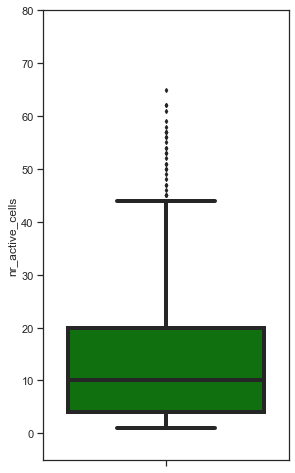

In [32]:
# for all data
#sns.histplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
           #  x = "nr_active_cells", stat='density', binwidth = 1)
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
sns.boxplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
             y = "nr_active_cells", fliersize=3,linewidth=4,palette=['green'])
plt.ylim(-5,80)

#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/awake_so_active_cells.pdf', dpi=600, format='pdf')

In [ ]:

sns.histplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
             x = "norm_active_cells", stat='density', binwidth = 1)
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/spindle_active_norm_cells_sws.pdf', dpi=300, format='pdf')

# Plotting of analyses

### Fraction of the same spindle/SO active cells in 2 subsequent SWS epochs


In [ ]:
plt.hist(data_list[56]["data"].shape

In [82]:
df_spindle_firing = pd.DataFrame()
old_spi_slo = []
old_index = []
old_mouse_name = []

for i, indDict in enumerate(data_list):
    
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])) and len(indDict['spi_osc_data']):
        
        if len(data_list[indDict['type3'][2]]['spi_osc_data']):
            
            if len(old_spi_slo):
                #pdb.set_trace()
                new_spi_slo = []
                new_spi_slo = data_list[indDict['type3'][2]]['spindle_top20_diff_firing'][0]
                fraction = len([rr for rr in old_spi_slo if rr in new_spi_slo]) / len(old_spi_slo)

                df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'fraction':[fraction],
                                                                     'name':old_mouse_name, 
                                                                     'epochID': old_index}), ignore_index = True)

                old_spi_slo = new_spi_slo
                old_index = i
                old_mouse_name = indDict['mouseName']


            else:
                old_spi_slo = indDict['spindle_top20_diff_firing'][0]
                old_index = i
                old_mouse_name = indDict['mouseName']
        

C:\Users\admin\Anaconda3\envs\sleep_project\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 6.0)

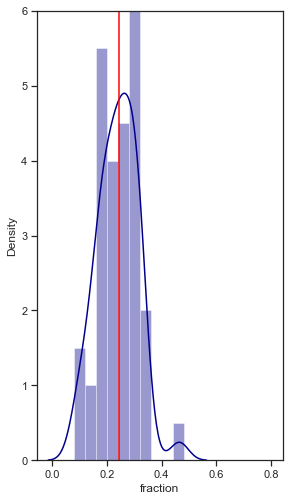

In [83]:
plt.rcParams["patch.force_edgecolor"] = True

sns.distplot(df_spindle_firing["fraction"],color='darkblue', bins = 20,hist=True, hist_kws={"range": [0.,0.8]})
plt.axvline(x=df_spindle_firing.fraction.median(),
            color='red')
plt.ylim(0,6)



In [ ]:
sns.boxplot(y="fraction", data=df_spindle_firing,dodge=False,fliersize=3,color='darkorange',linewidth=4)
plt.ylim(0,.6)
#if save_file:
 #   df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/Type3_fr_based_on_top20%_divided_thirds_slo_active.csv')

### Read and write data as JSON file

In [ ]:
with open('I:/Marco/analysis_nima/allData_JSON/fullData_with_analyses.json', 'w') as wr:
    json.dump(data_list , wr, cls=NumpyEncoder)

In [ ]:
with open(r"I:/Marco/analysis_nima/allData_JSON/fullData_with_analyses.json", "r") as read_file:
    data_list = json.load(read_file)

In [ ]:
# change lists to array
[data_dict.update({key: np.asarray(data_dict[key])}) for data_dict in data_list for key in data_dict.keys() if isinstance(data_dict[key], list)];